# John Schiff - Homework 05

## Due Tuesday, March 29th

In [133]:
%matplotlib inline
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import shapely.geometry
import shapely.ops
from scipy import spatial
from scipy import interpolate
import scipy.interpolate
import pandas as pd
# import cartopy.crs as ccrs
# import cartopy.io.shapereader as shpreader

### 1. Flyover states

_[This is very similar to the exercise done in class. This is a continuation.]_

What states do you see when you fly from LA (airport code LAX) to NYC (airport code EWR)?

> LAX: 33.9425° N, 118.4081° W

> EWR: 40.6925° N, 74.1686° W

Load in the `states_21basic` shapefile using these commands:

    from mpl_toolkits.basemap import Basemap
    m = Basemap(llcrnrlon=-150.,llcrnrlat=20.,
            urcrnrlon=-50.,urcrnrlat=50.,
            rsphere=(6378137.00,6356752.3142),
            resolution='l',projection='merc',
            lat_0=40.,lon_0=-100.,lat_ts=20.)
    m.readshapefile('../materials/states_21basic/states', 'states')

The boundary information for all of the states is now held in an attribute of the map object `m.states`, which is a list of lists of x-y pairs denoting the boundaries. Next use the `m.gcpoints` function to get the points along the great circle path. Convert all of these things into Shapely objects, and check for intersections. Add a buffer of 100km to the flight path to see what states you might potentially see along the way. Use this analysis to provide the following:

1. Create and display a map that shows the flight path, with the states that are seen along the flight path clearly highlighted in some way.

2. Use the information in m.states_info to extract and print a list containing the names of the states seen, with unique names. (see `np.unique`)


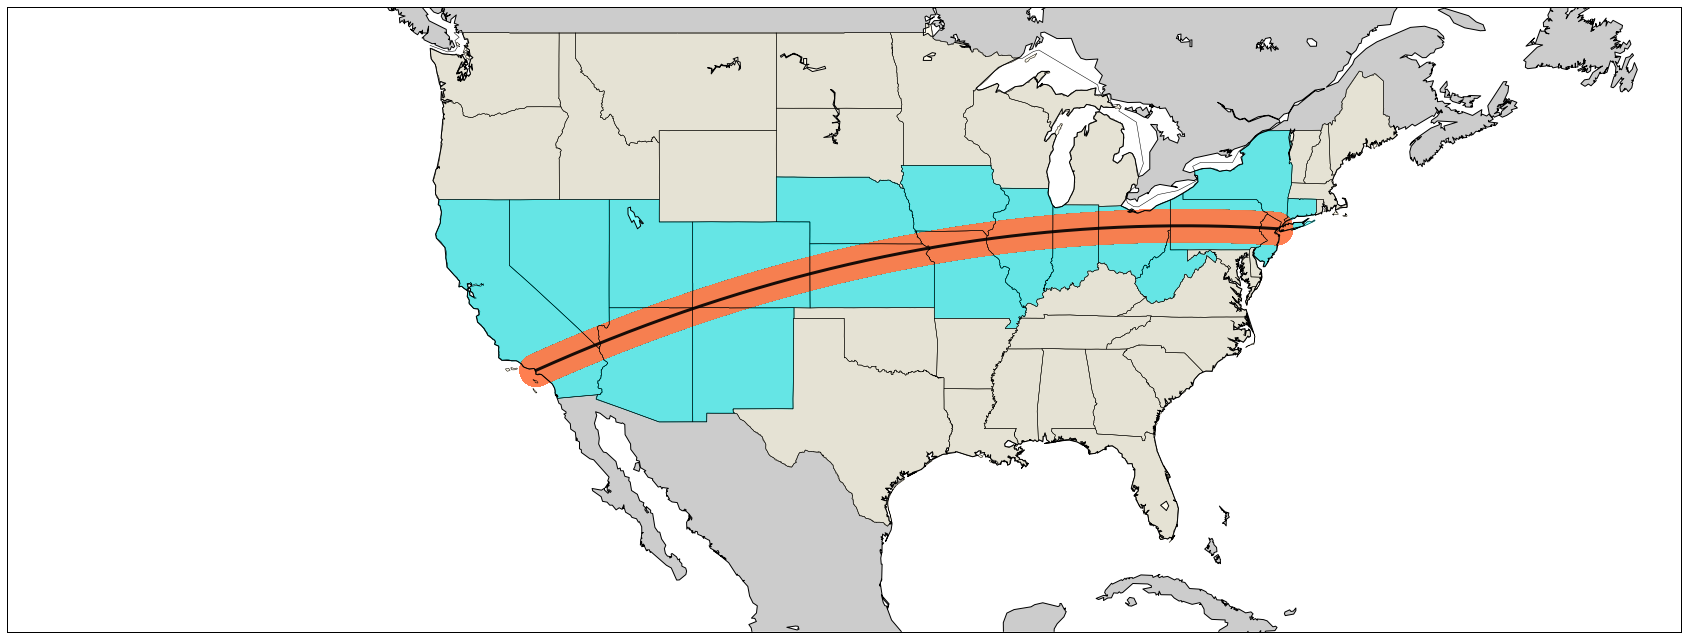

In [192]:
fig = plt.figure(figsize=(30,15))
from mpl_toolkits.basemap import Basemap
m = Basemap(llcrnrlon=-150.,llcrnrlat=20.,
        urcrnrlon=-50.,urcrnrlat=50.,
        rsphere=(6378137.00,6356752.3142),
        resolution='l',projection='merc',
        lat_0=40.,lon_0=-100.,lat_ts=20.)
m.readshapefile('states_21basic/states', 'states')
lat1 = 33.9425
lon1 = -118.4081
# lat1 = 37.6213
# lon1 = -122.3790 coordinates for SFO, did for fun
lat2 = 40.6925
lon2 = -74.1686
m.fillcontinents();
m.drawcoastlines()
m.drawcountries()
x,y = m.gcpoints(lon1,lat1,lon2,lat2,1000)
# buffered = m.gcpoints(lon1,lat1,lon2,lat2,1000).buffer(0.3)
# mapline = shapely.geometry.LineString((lon1, lat1, lon2,lat2))
# buffered = mapline.buffer(0.3)
# m.drawgreatcircle(lon1,lat1,lon2,lat2, del_s=100.0, lw=1, color='k')
plt.plot(x,y,'black',lw=3, alpha=0.9)
# plt.fill(*buffered.boundary.xy, alpha=0.2)

point=[]
for i in range(0,len(x)):
    point.append(shapely.geometry.Point(x[i], y[i]))
line = shapely.geometry.LineString(point).buffer(100000) # 100 km (100000 m) buffer
polys=[]
for state in m.states:
    polys.append(shapely.geometry.Polygon(state))
    
List=[]
for i in range(len(polys)):
    if polys[i].intersects(line):
        color = 'aqua'
        List.append(m.states_info[i]['STATE_NAME'])
    else:
        color = 'cornsilk'
    coords = shapely.ops.cascaded_union(polys[i].boundary).coords[:]
    x, y = zip(*coords)
    plt.fill(x, y, color=color, alpha=0.5) # Fill with respective colors assigned to the different points
    plt.fill(*line.boundary.xy, color='coral',alpha=0.1)
#     plt.plot(x, y, '-')

In [122]:
# state_names = []
# for state in m.states_info:
#     state_names.append(STATE_NAME)
    
# state_names


# for state in m.states_info:
#     print(state)

### 2. Area in a Voronoi diagram

Given the series of points:

     np.array([[ 0.77354201,  0.34072038],
               [ 0.43807549,  0.93001924],
               [ 0.5624092 ,  0.79438991],
               [ 0.02536295,  0.46180244],
               [ 0.59533179,  0.07522803],
               [ 0.47867418,  0.70302822],
               [ 0.30371564,  0.83135442],
               [ 0.5856915 ,  0.16340903],
               [ 0.14700491,  0.60268997],
               [ 0.97098631,  0.51692456]])
               
create a Voronoi diagram, and calculate the area contained in the finite regions. What fraction of the total area is at least 0.001 unit away from any boundary? 0.01 away? And 0.1 away?


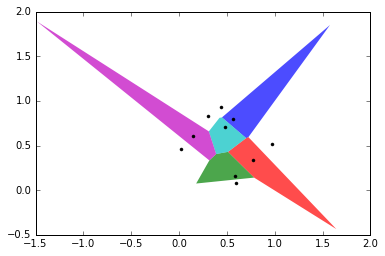

In [100]:
arr = np.array([[ 0.77354201,  0.34072038],
           [ 0.43807549,  0.93001924],
           [ 0.5624092 ,  0.79438991],
           [ 0.02536295,  0.46180244],
           [ 0.59533179,  0.07522803],
           [ 0.47867418,  0.70302822],
           [ 0.30371564,  0.83135442],
           [ 0.5856915 ,  0.16340903],
           [ 0.14700491,  0.60268997],
           [ 0.97098631,  0.51692456]])

vor = spatial.Voronoi(arr)

for indices in vor.regions:
    if not indices: 
        continue
    if -1 in indices:
        continue
    plt.fill(vor.vertices[indices, 0], vor.vertices[indices, 1], edgecolor='none', alpha=0.7)

plt.plot(arr[:, 0], arr[:, 1], '.k')

In [118]:
v = vor.vertices
poly_v = shapely.geometry.Polygon(v)

poly_v.area

0.2889023415712948

In [120]:
vconvex = poly_v.convex_hull
vconvex.area

4.408336405791147

### 3. 2D interpolation

Data (found in `python4geosciences/data/MS03_L15.txt`) gathered from a field cruise out of the TAMU Oceanography department is randomly located in space (that is, unstructured) because of the nature of the measurement: the instrument is lowered into the water from a ship, and is brought up and down through the water column as the ship moves to get a sampling of the fields.

Read in the data file and plot the temperature in a `scatter` plot as a function of depth and latitude. Next, interpolate the temperature data to be on a uniform grid (to make it structured). Now, plot it using `contourf`, which requires structured data. Experiment with different spacing in your uniform grid, and with different numbers of contours to see how the results change, and choose values that provide a nice-looking image which closely resembles the original data.

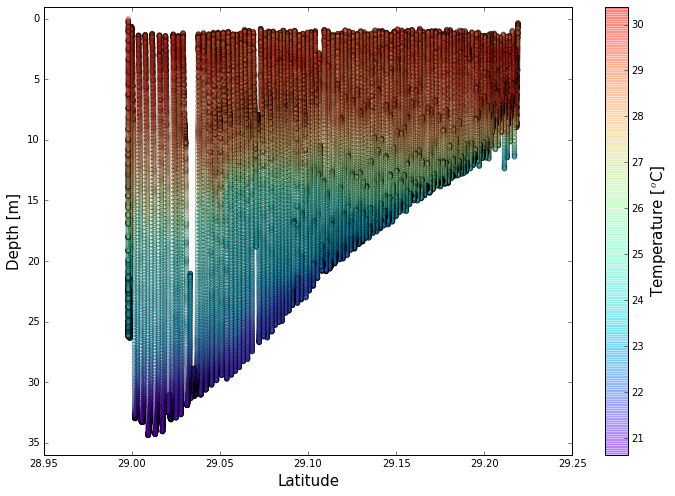

In [43]:
# Read in the data (can also be done using pandas, see below)
f = np.genfromtxt('MS03_L15.txt', skip_header=114)

fig = plt.figure(figsize=(10,7))
lat = f[:,0]
lon = f[:,1]
temp = f[:,15]
depth = f[:,2]

# a = plt.scatter(depth,temp,c=lat,cmap='cool')
a = plt.scatter(lat,depth,c=temp,cmap='rainbow', alpha=0.3) # Make it transparent so colors easier to see
plt.xlabel('Latitude', size=15)
plt.ylabel('Depth [m]', size=15)
plt.ylim(-1,36)
plt.gca().invert_yaxis()
cb02 = plt.colorbar(a)
cb02.set_label('Temperature [$^{o}$C]', size=15)
fig.tight_layout()

# Contour plot will be temperature as a function of depth(y) and latitude (x)

In [36]:
# Set up a regular grid of interpolation points
xi, yi = np.linspace(lat.min(), lat.max(), 500), np.linspace(depth.min(), depth.max(), 500)
xi, yi = np.meshgrid(xi, yi)

In [49]:
# Interpolate
zi = scipy.interpolate.griddata((lat, depth), temp, (xi, yi), method='linear')
zi2 = scipy.interpolate.griddata((lat, depth), temp, (xi, yi), method='nearest')

# We interpolate because the temperature data is not structured
# It will be a function of both depth and latitude

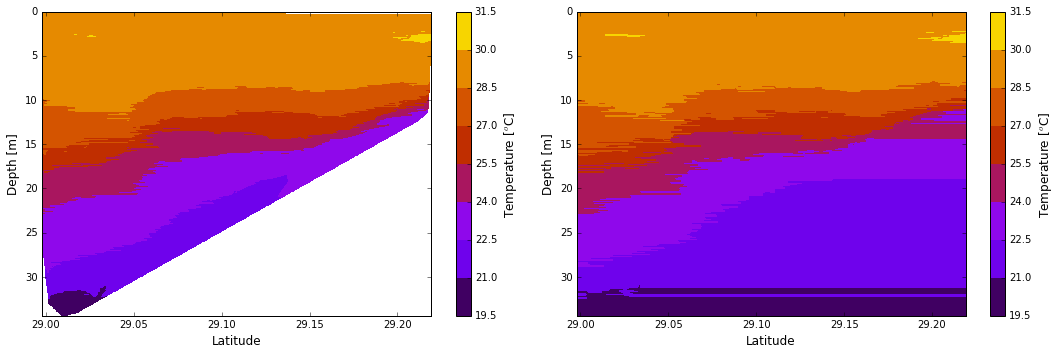

In [195]:
fig = plt.figure(figsize=(15,5))

ax0 = fig.add_subplot(1,2,1) # Interpolated data using LINEAR method
cp0 = ax0.contourf(xi,yi,zi, cmap='gnuplot')
cb0 = plt.colorbar(cp0, ax=ax0)
# axes[0].gca().invert_yaxis()
ax0.set_ylabel('Depth [m]', size=12)
ax0.set_xlabel('Latitude', size=12)
cb0.set_label('Temperature [$^{o}$C]', size=12)
ax0.invert_yaxis()


ax1 = fig.add_subplot(1,2,2) # Interpolated data using NEAREST NEIGHBOR method
cp1 = ax1.contourf(xi,yi,zi2, cmap='gnuplot')
cb1 = plt.colorbar(cp1, ax=ax1)
ax1.set_ylabel('Depth [m]', size=12)
ax1.set_xlabel('Latitude', size=12)
cb1.set_label('Temperature [$^{o}$C]', size=12)
ax1.invert_yaxis()

fig.tight_layout()

In [69]:
# fig = plt.figure(figsize=(10,6))
# contour = plt.contourf(xi,yi,zi, cmap='rainbow') # plotting the interpolated data

# plt.gca().invert_yaxis()
# plt.ylabel('Depth [m]', size=15)
# plt.xlabel('Latitude', size=15)
# cbcontour = plt.colorbar(contour)
# cbcontour.set_label('Temperature [$^{o}$C]', size=15)
# plt.ylim((35,0))
# # plt.xlim()
# fig.tight_layout()

In [130]:
# # Read in the data via pandas

# dt = pd.read_table('MS03_L15.txt', header=None, skiprows=114, delim_whitespace=True)
# lat = dt[0]
# lon = dt[1]
# temp = dt[15]
# depth = dt[2]

### 4. (Grad) Area of Greenland and Australia in different projections

Set up Basemap instances of the following projections: Mercator, Robinson, and Mollweide; make sure that all three projections are set up to show both Greenland and Australia at the same time (this is necessary for Mercator in particular). Plot them side-by-side to see how they compare.

Next, read in the shape files for Greenland and Australia, found in the `data` directory; you can do this with something like the following (but you might need to change the directory path):

> m.readshapefile('../python4geosciences/data/GRL_adm_shp/GRL_adm0', 'greenland', drawbounds=False)
> m.readshapefile('../python4geosciences/data/AUS_adm_shp/AUS_adm0', 'australia', drawbounds=False)

where `m` is a `Basemap` instance. This gives you a series of polygons that make up each country, saved in `m.greenland` and `m.australia`. Find the area of the two countries in each projection and compare them. What is the area of Australia relative to the area of Greenland for each projection, and how does this compare to what it is in reality?

<bound method Figure.tight_layout of <matplotlib.figure.Figure object at 0x1127cd240>>

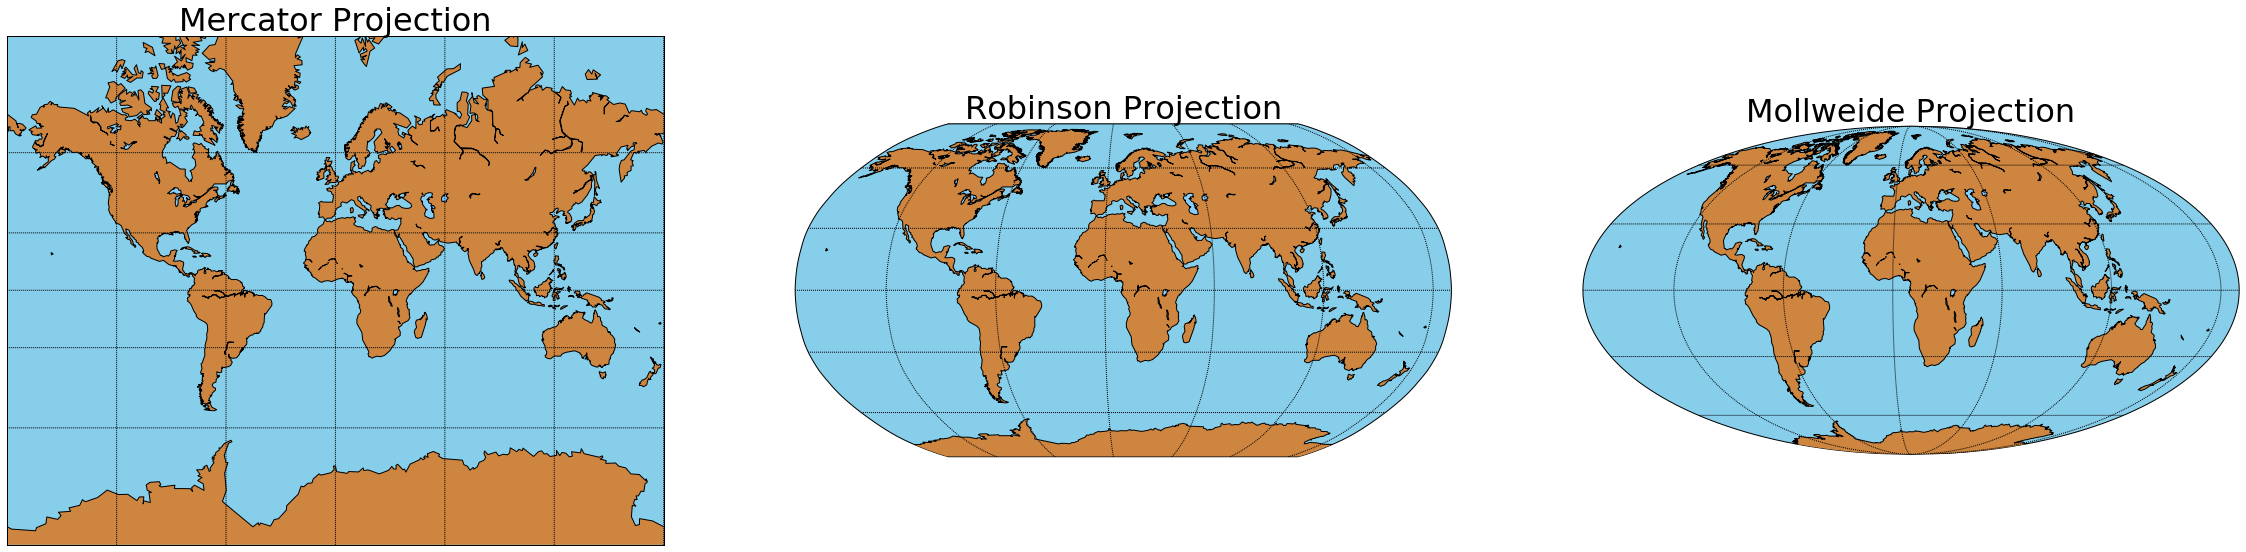

In [134]:
m = Basemap()
fig, axes = plt.subplots(1, 3, figsize=(40,30))

# Mercador Projection

axes[0].set_title('Mercator Projection', size=32)
merc = Basemap(projection='merc',
               llcrnrlat=-80,
               urcrnrlat=80,\
            llcrnrlon=-180,
               urcrnrlon=180,
               lat_ts=20,
               resolution='c', # crude resolution
               ax=axes[0])

merc.drawmapboundary(fill_color='skyblue')
merc.fillcontinents(color='peru',lake_color='lightskyblue')
merc.drawcoastlines()
merc.drawparallels(np.arange(-90.,91.,30.))
merc.drawmeridians(np.arange(-180.,181.,60.))

# Robinson Projection

axes[1].set_title('Robinson Projection', size=32)
rob = Basemap(projection='robin', lon_0 = 10, lat_0 = 50, ax=axes[1])

rob.drawmapboundary(fill_color='skyblue')
rob.fillcontinents(color='peru',lake_color='lightskyblue')
rob.drawcoastlines()
rob.drawparallels(np.arange(-90.,120.,30.))
rob.drawmeridians(np.arange(0.,420.,60.))

# Mollweide Projection

axes[2].set_title('Mollweide Projection', size=32)
moll = Basemap(projection='moll', lon_0 = 10, lat_0 = 50, ax=axes[2])

moll.drawmapboundary(fill_color='skyblue')
moll.fillcontinents(color='peru',lake_color='lightskyblue')
moll.drawcoastlines()
moll.drawparallels(np.arange(-90.,120.,30.))
moll.drawmeridians(np.arange(0.,420.,60.))

fig.tight_layout

In [135]:
m.readshapefile('GRL_adm_shp/GRL_adm0', 'greenland', drawbounds=False) 
m.readshapefile('AUS_adm_shp/AUS_adm0', 'australia', drawbounds=False)

(1,
 5,
 [112.91972351074276, -55.11694335937477, 0.0, 0.0],
 [159.25608825683616, -9.221098899841202, 0.0, 0.0])

In [136]:
rob = Basemap(projection='robin', lon_0 = 10, lat_0 = 50, ax=axes[1])

rob.drawmapboundary(fill_color='skyblue')
rob.readshapefile('AUS_adm_shp/AUS_adm0', 'australia', drawbounds=True)
# plt.show()

(1,
 5,
 [112.91972351074276, -55.11694335937477, 0.0, 0.0],
 [159.25608825683616, -9.221098899841202, 0.0, 0.0],
 <matplotlib.collections.LineCollection at 0x169f295f8>)